<a href="https://colab.research.google.com/github/malihasameen/receipts_detection/blob/master/receipts_detection_resnet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Class Object Detection in Receipts

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Configs and Hyper Parameters

In [0]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/Tony607/object_detection_demo'

# Number of training steps.
num_steps = 1000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'faster_rcnn_resnet101': {
        'model_name': 'faster_rcnn_resnet101_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_resnet101'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the object_detection_demo repository or your fork.

In [3]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'object_detection_demo'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 11.16 MiB | 670.00 KiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/object_detection_demo
Already up to date.


## Install Packages

In [4]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 130963 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

## Generate TFRecords

In [5]:
# Change Directory
%cd "/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/"
!ls

/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection
faster_rcnn_inception_v2_pets.config  receipts_detection-inception-v2.ipynb
fine_tuned_model		      receipts_detection-resnet101.ipynb
generate_tfrecord.py		      test.record
images				      train.record
labelmap.pbtxt


In [6]:
# Generate TFRecords
!python generate_tfrecord.py --csv_input=images/train_labels.csv --image_dir=images/train --output_path=train.record
!python generate_tfrecord.py --csv_input=images/test_labels.csv --image_dir=images/test --output_path=test.record

Successfully created the TFRecords: /content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/train.record
Successfully created the TFRecords: /content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/test.record


Create a new file and save it as `labelmap.pbtxt` in the `\root\models\research\object_detection\training` folder. 

In [8]:
# labelmap.pbtxt
%cd /content/models/research/object_detection/
!mkdir training
!cp -r "/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/labelmap.pbtxt" "training/"
!ls /content/models/research/object_detection/training/

/content/models/research/object_detection
mkdir: cannot create directory ‘training’: File exists
labelmap.pbtxt


In [9]:
# Copy train.record and test.record file
!cp -r "/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/train.record" "."
!cp -r "/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/test.record" "."
!ls

anchor_generators		     meta_architectures
box_coders			     metrics
builders			     model_hparams.py
CONTRIBUTING.md			     model_lib.py
core				     model_lib_test.py
data				     model_lib_v2.py
data_decoders			     model_lib_v2_test.py
dataset_tools			     model_main.py
dockerfiles			     models
eval_util.py			     model_tpu_main.py
eval_util_test.py		     object_detection_tutorial.ipynb
exporter.py			     predictors
exporter_test.py		     protos
export_inference_graph.py	     __pycache__
export_tflite_ssd_graph_lib.py	     README.md
export_tflite_ssd_graph_lib_test.py  samples
export_tflite_ssd_graph.py	     test_ckpt
g3doc				     test_data
inference			     test_images
__init__.py			     test.record
inputs.py			     tpu_exporters
inputs_test.py			     training
legacy				     train.record
matchers			     utils


## Download Model

In [10]:
# # Download and extract the model
# !wget -c http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
# # Untar dataset
# !tar -xvzf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

%cd /content/models/research/object_detection

import os
import shutil
import glob
import urllib.request
import tarfile

MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/object_detection'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

/content/models/research/object_detection


## Train Configurations
Navigate to C:\tensorflow1\models\research\object_detection\samples\configs and copy the faster_rcnn_inception_v2_pets.config file into the \object_detection\training directory. Then, open the file with a text editor. There are several changes to make to the .config file, mainly changing the number of classes and examples, and adding the file paths to the training data.

- Line 9. Change num_classes to the number of different objects you want the classifier to detect. For the above basketball, shirt, and shoe detector, it would be num_classes : 3 .

- Line 106. Change fine_tune_checkpoint to:

  - fine_tune_checkpoint : "C:/tensorflow1/models/research/object_detection/faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt"
- Lines 123 and 125. In the train_input_reader section, change input_path and label_map_path to:

  - input_path : "C:/tensorflow1/models/research/object_detection/train.record"
  - label_map_path: "C:/tensorflow1/models/research/object_detection/training/labelmap.pbtxt"
- Line 130. Change num_examples to the number of images you have in the \images\test directory.

- Lines 135 and 137. In the eval_input_reader section, change input_path and label_map_path to:

  - input_path : "C:/tensorflow1/models/research/object_detection/test.record"
  - label_map_path: "C:/tensorflow1/models/research/object_detection/training/labelmap.pbtxt"

Save the file after the changes have been made. That’s it! The training job is all configured and ready to go!

In [11]:
%cd ..
from object_detection.utils import label_map_util

def get_num_classes(pbtxt_fname):
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

/content/models/research


In [0]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
label_map_pbtxt_fname = "/content/models/research/object_detection/training/labelmap.pbtxt"
train_record_fname = "/content/models/research/object_detection/train.record"
test_record_fname = "/content/models/research/object_detection/test.record"
fine_tune_checkpoint = "/content/models/research/object_detection/" + MODEL + "/model.ckpt"

In [0]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [24]:
!cp -r "/content/models/research/object_detection/samples/configs/"{pipeline_file} "object_detection/training/"
!ls object_detection/training

checkpoint				     labelmap.pbtxt
events.out.tfevents.1563778177.dc73ac448993  model.ckpt-0.data-00000-of-00001
faster_rcnn_resnet101_pets.config	     model.ckpt-0.index
graph.pbtxt				     model.ckpt-0.meta


## Run Tensorboard

In [25]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2019-07-22 06:52:50--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.232.40.183, 52.200.233.201, 54.164.181.42, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.232.40.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  12.98M  5.28MB/s    in 2.5s    

2019-07-22 06:52:53 (5.28 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
model_dir = "object_detection/training/"

In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

## Get Tensorboard link

In [29]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://befe2576.ngrok.io


## Training

In [30]:
# Start Training
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path=object_detection/training/{pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}
# !python object_detection/legacy/train.py --logtostderr --train_dir={model_dir} --pipeline_config_path=object_detection/training/{pipeline_file}

W0722 06:53:16.694821 140318887909248 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0722 06:53:16.720566 140318887909248 deprecation_wrapper.py:119] From /content/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0722 06:53:16.730158 140318887909248 deprecation_wrapper.py:119] From /content/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0722 06:53:16.741554 140318887909248 deprecation_wrapper.py:119] From /content/models/research/object_detection/model_main.py:109: The name tf.app.run 

In [0]:
# !mkdir object_detection/eval
# !python object_detection/legacy/eval.py --logtostderr --pipeline_config_path=object_detection/training/{pipeline_file} --checkpoint_dir=object_detection/training/ --eval_dir=object_detection/eval/

In [31]:
!ls {model_dir}

checkpoint				     model.ckpt-1000.index
eval_0					     model.ckpt-1000.meta
events.out.tfevents.1563778177.dc73ac448993  model.ckpt-285.data-00000-of-00001
events.out.tfevents.1563778420.dc73ac448993  model.ckpt-285.index
export					     model.ckpt-285.meta
faster_rcnn_resnet101_pets.config	     model.ckpt-567.data-00000-of-00001
graph.pbtxt				     model.ckpt-567.index
labelmap.pbtxt				     model.ckpt-567.meta
model.ckpt-0.data-00000-of-00001	     model.ckpt-849.data-00000-of-00001
model.ckpt-0.index			     model.ckpt-849.index
model.ckpt-0.meta			     model.ckpt-849.meta
model.ckpt-1000.data-00000-of-00001


## Exporting a Trained Inference Graph


In [32]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=object_detection/training/{pipeline_file} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

object_detection/training/model.ckpt-1000
W0722 07:44:10.235981 140137653438336 deprecation_wrapper.py:119] From /content/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0722 07:44:10.245831 140137653438336 deprecation_wrapper.py:119] From /content/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0722 07:44:10.256723 140137653438336 deprecation_wrapper.py:119] From /content/models/research/object_detection/export_inference_graph.py:162: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0722 07:44:10.257280 140137653438336 deprecation_wrapper.py:119] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

W0722 07:44:10.262972 140137653438336 deprecation_wrapper.py:119] From /content/models/re

In [0]:
!cp -r "/content/models/research/fine_tuned_model" "/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/"

In [34]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download .pb File

In [0]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [36]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 182M Jul 22 07:44 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


## Run Inference Test

In [37]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join("/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/images", "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)

TEST_IMAGE_PATHS = []

for file in os.listdir(PATH_TO_TEST_IMAGES_DIR):
  if file.endswith('.jpg'):
    file_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, file)
    TEST_IMAGE_PATHS.append(file_path)

print(len(TEST_IMAGE_PATHS))
print(TEST_IMAGE_PATHS)
  
# TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
# assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
# print(TEST_IMAGE_PATHS)

16
['/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/images/test/48d61f7ed5e346da61761ebc3e978df4.jpg', '/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/images/test/consulting-template.jpg', '/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/images/test/gst-invoice-template-excel-malaysia-malaysia-invoice-template-professional-invoices-template-best-of-tax-ideas.jpg', '/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/images/test/fedex-freight-commercial-invoice-fedex-commercial-invoice-template-microsoft-excel-775x1024.jpg', '/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/images/test/downnload-microsoft-invoice-template-sample-business-printable.jpg', '/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/images/test/Easy-to-Use-Invoice-Template.jpg', '/content/gdrive/My Drive/Google Colab Workspace/Receipts_Detection/images/test/gst-invoice-template-word-gst-tax-invoice-format-in-

/content/models/research/object_detection


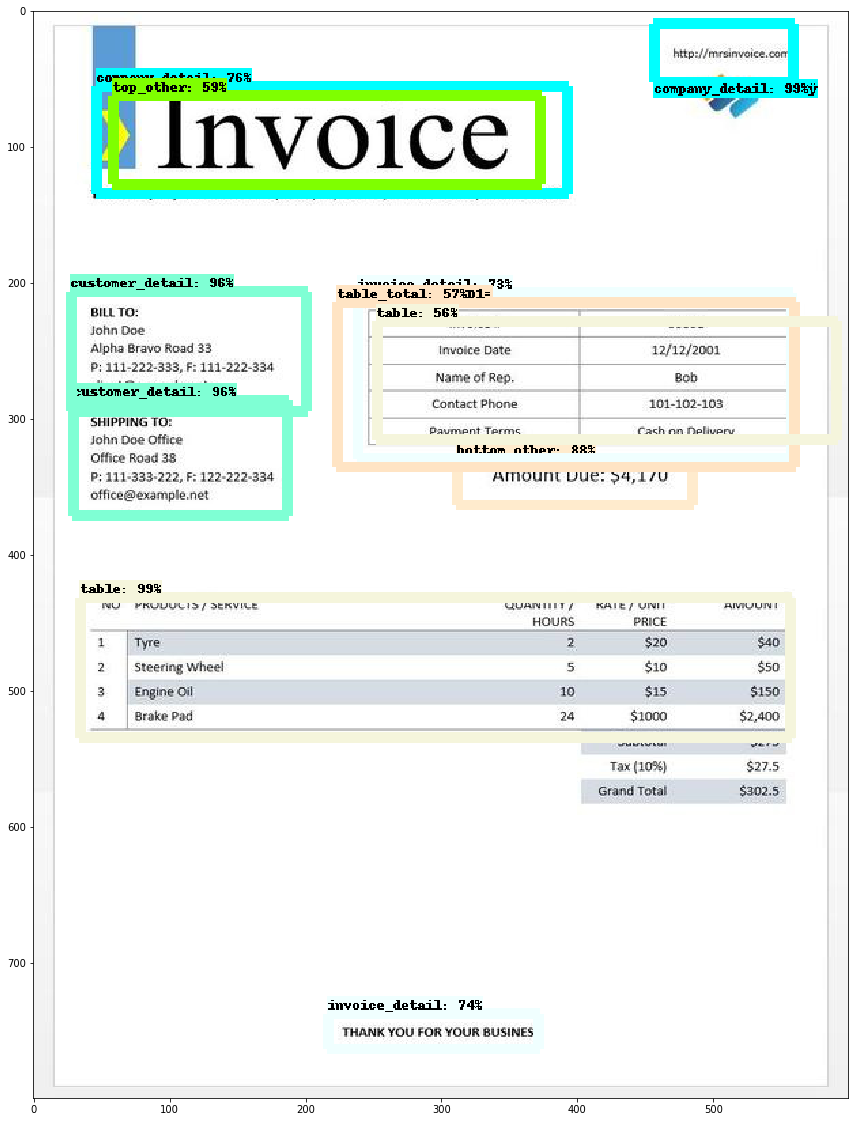

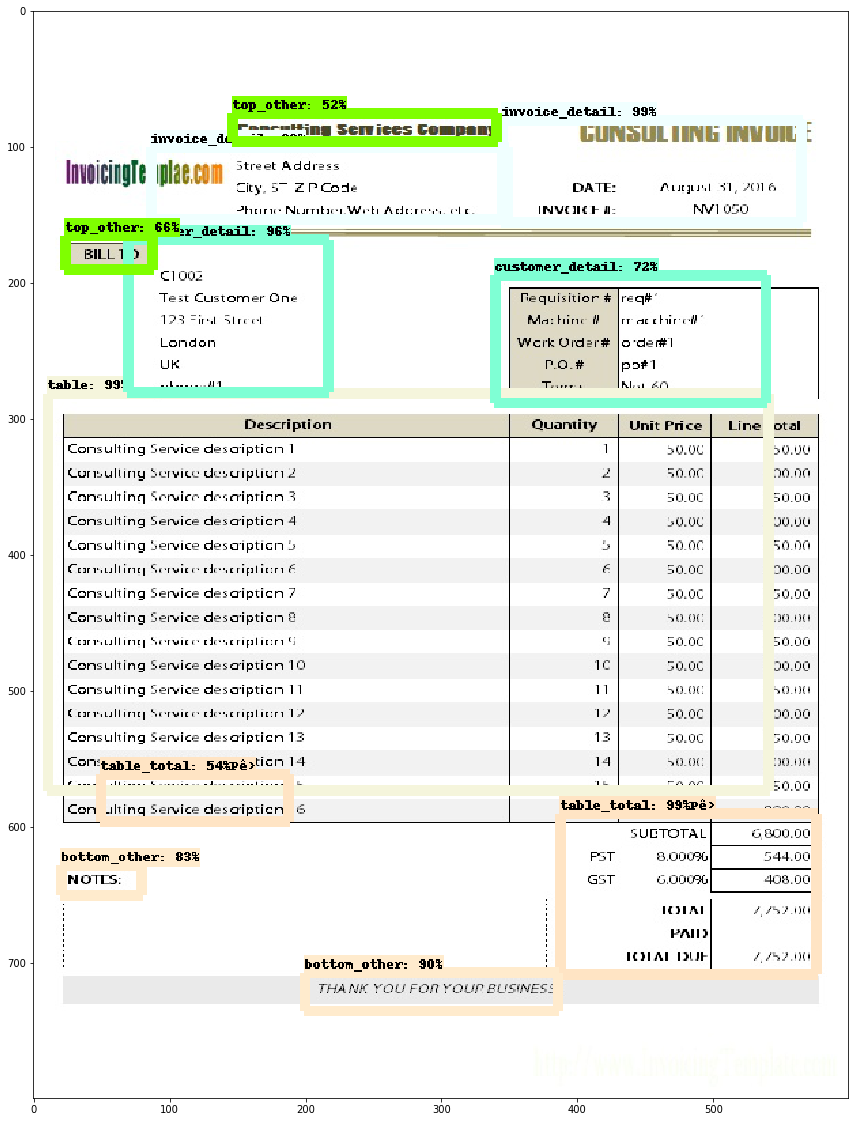

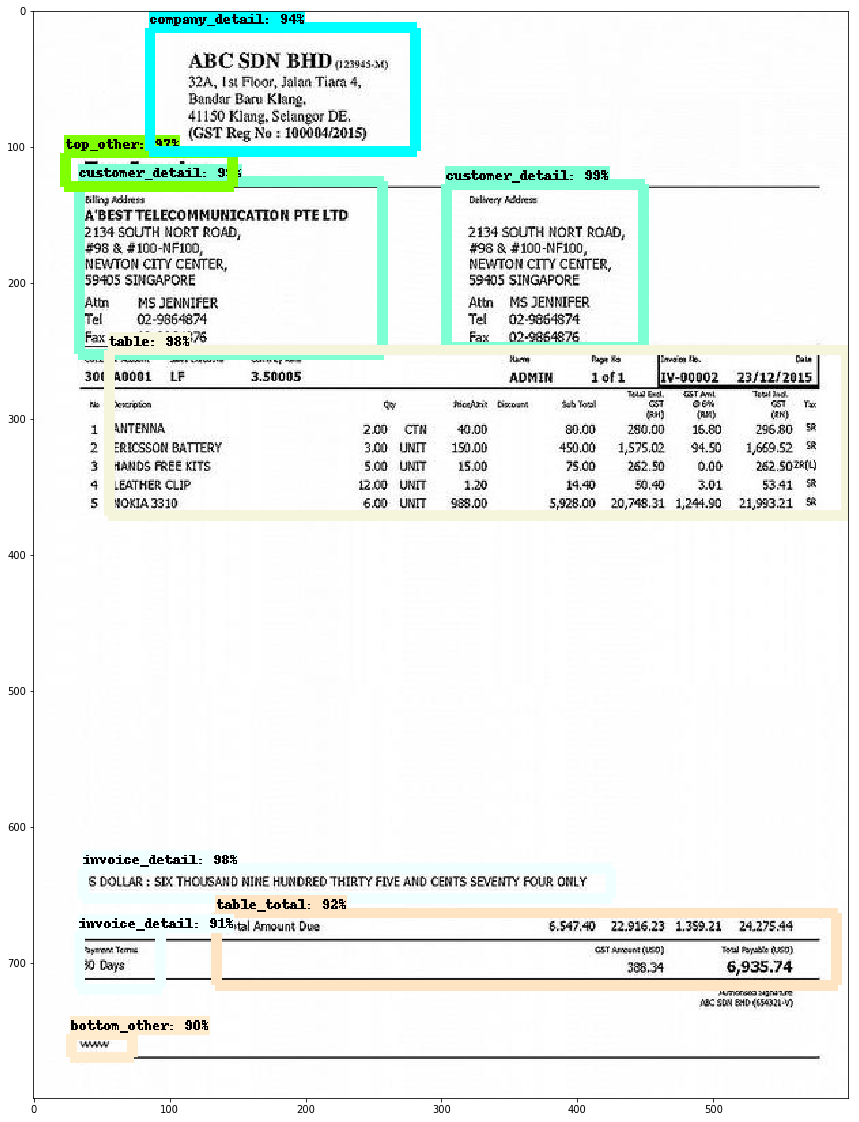

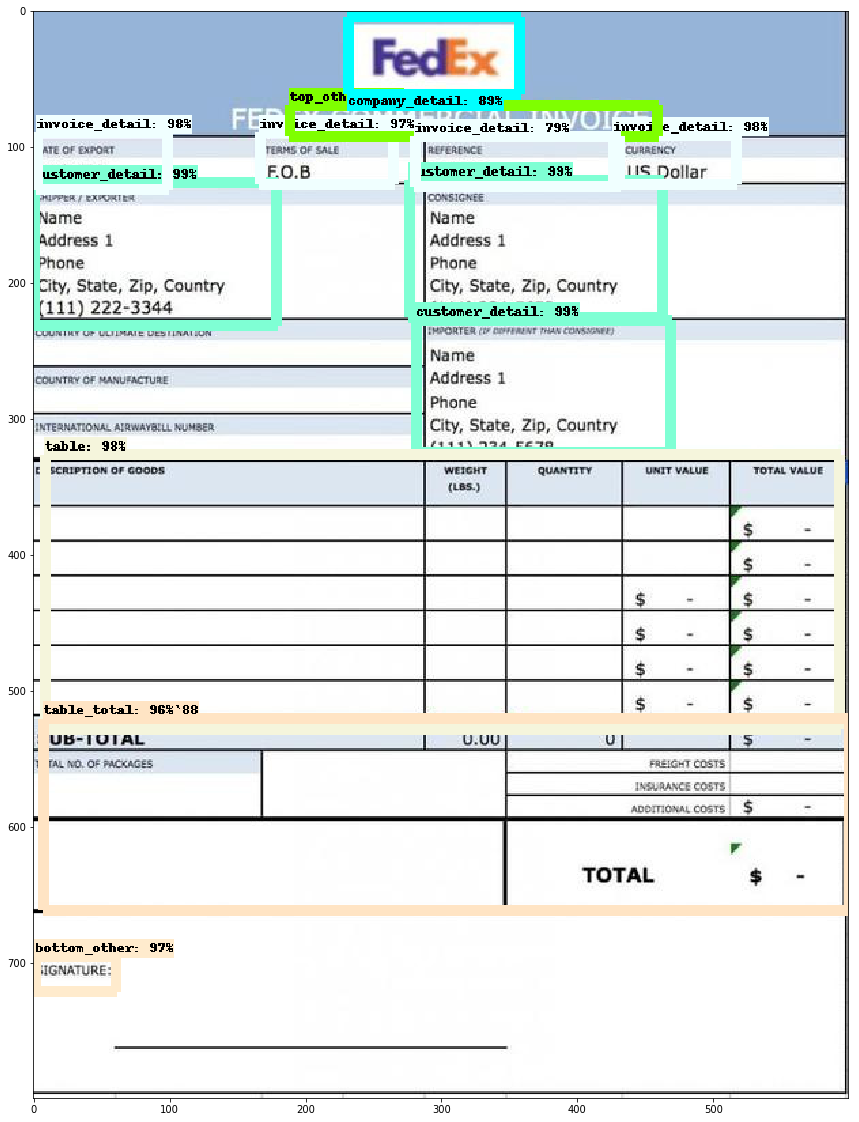

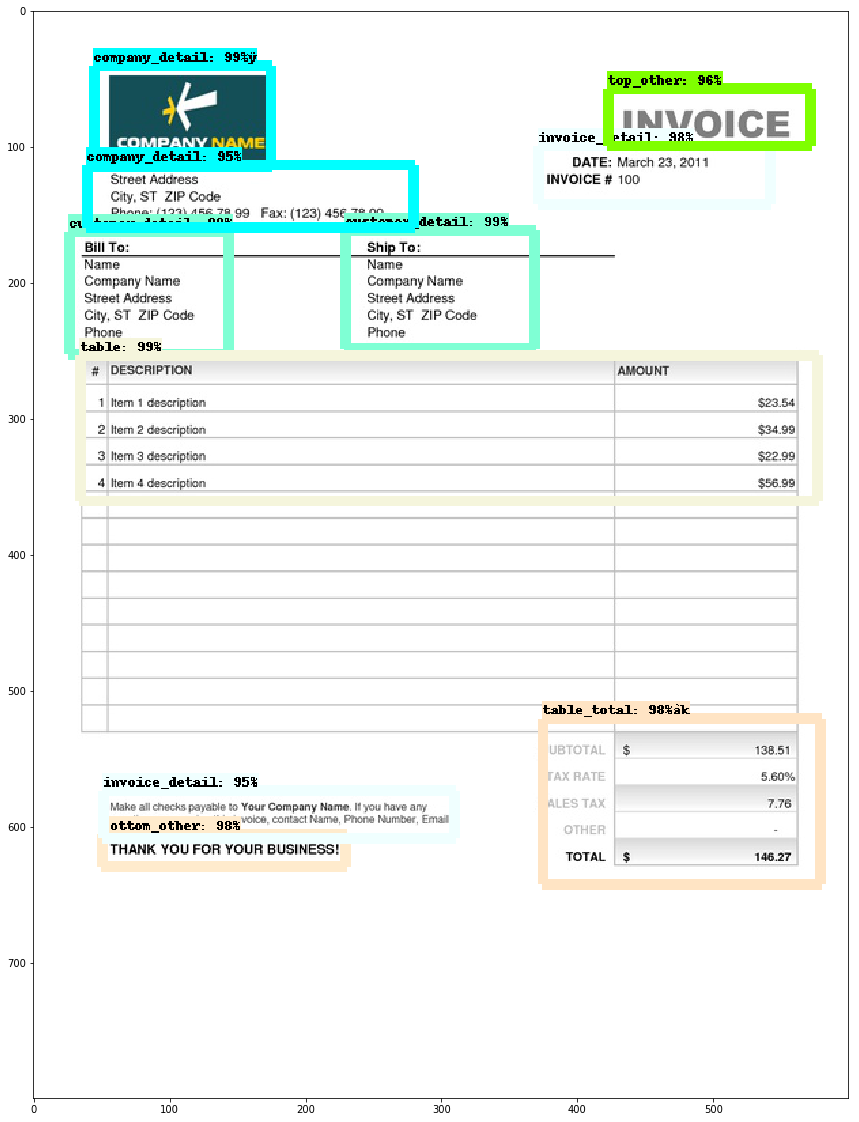

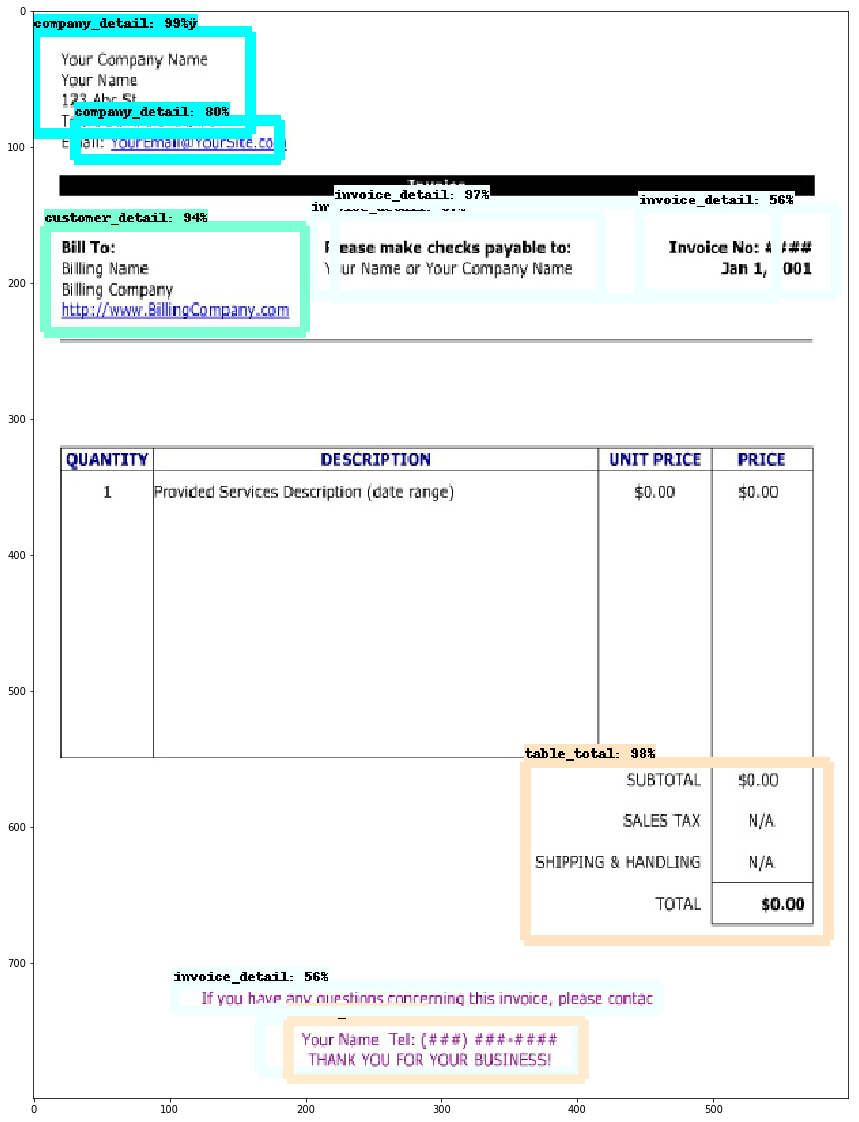

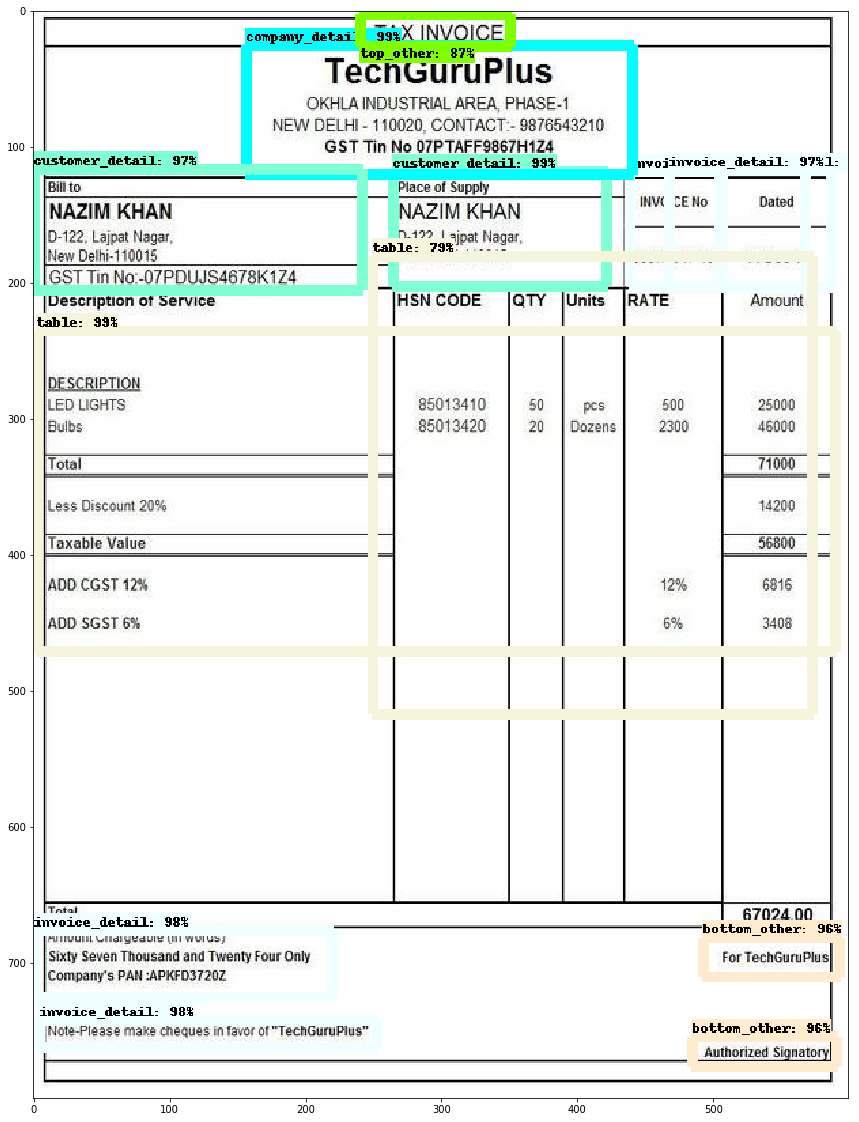

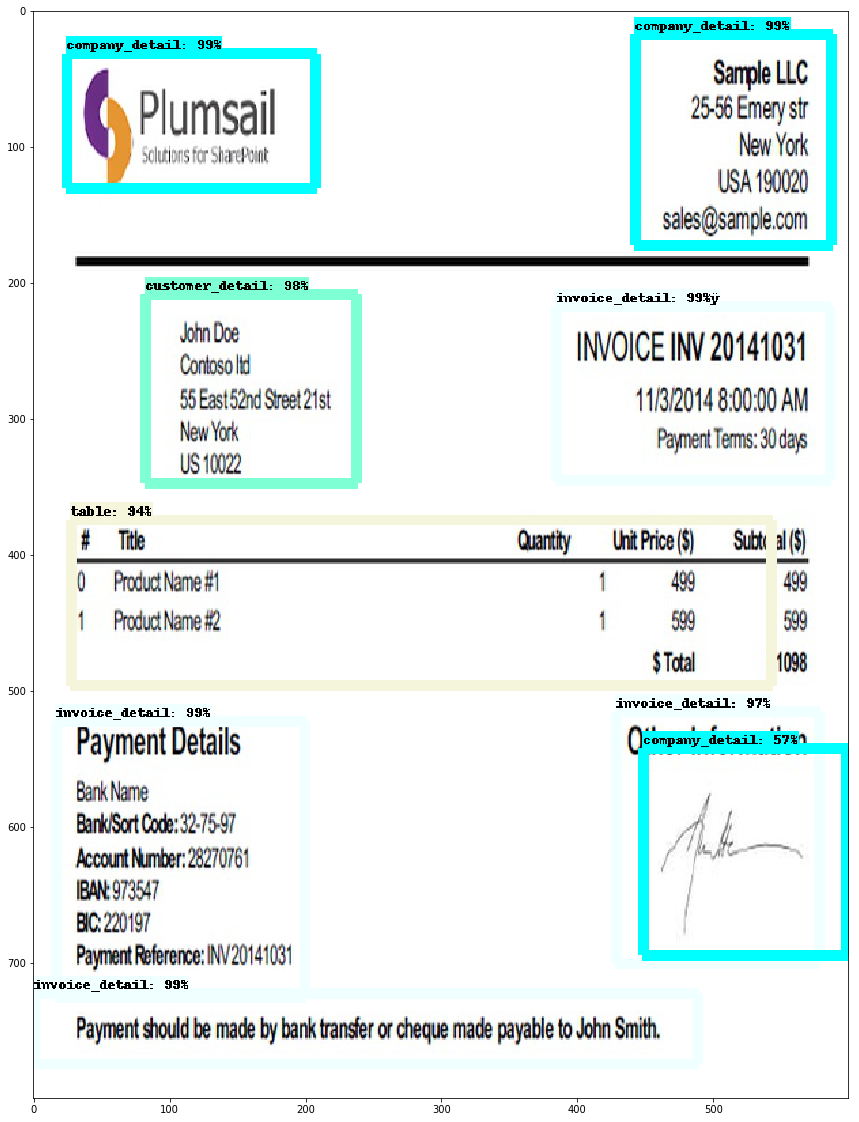

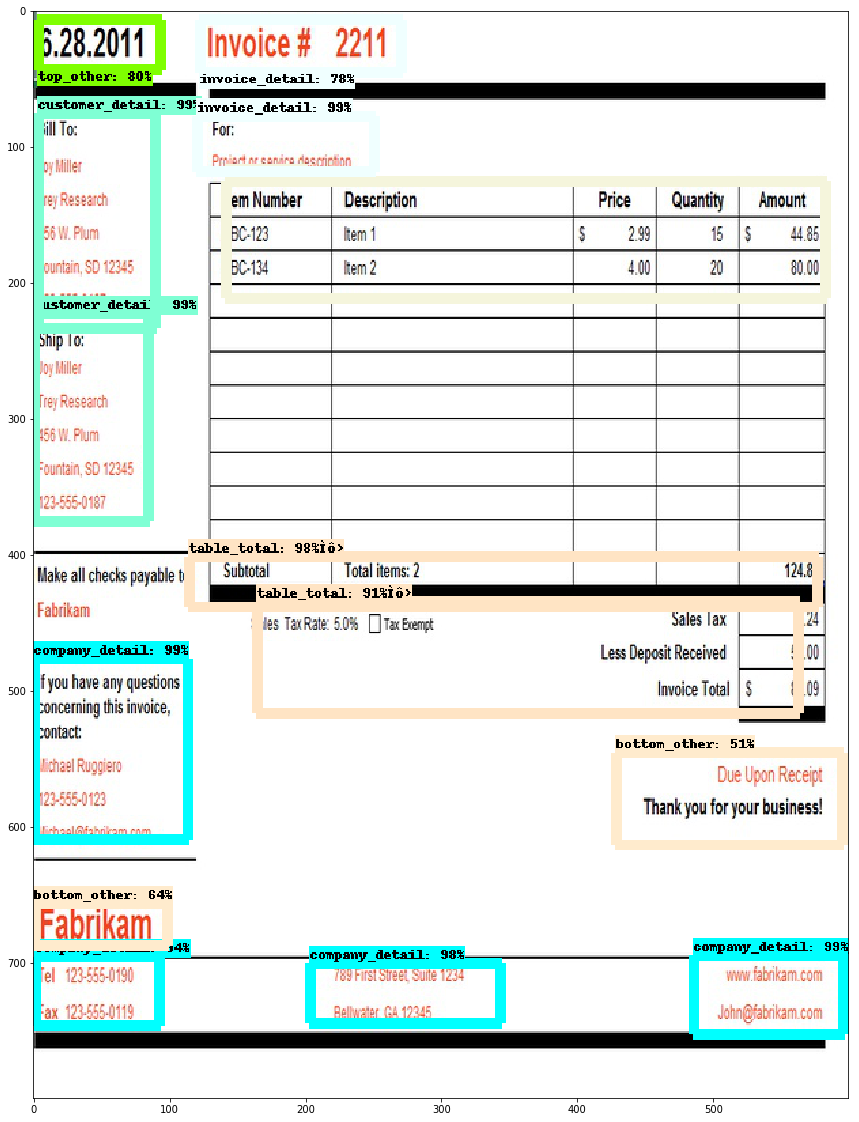

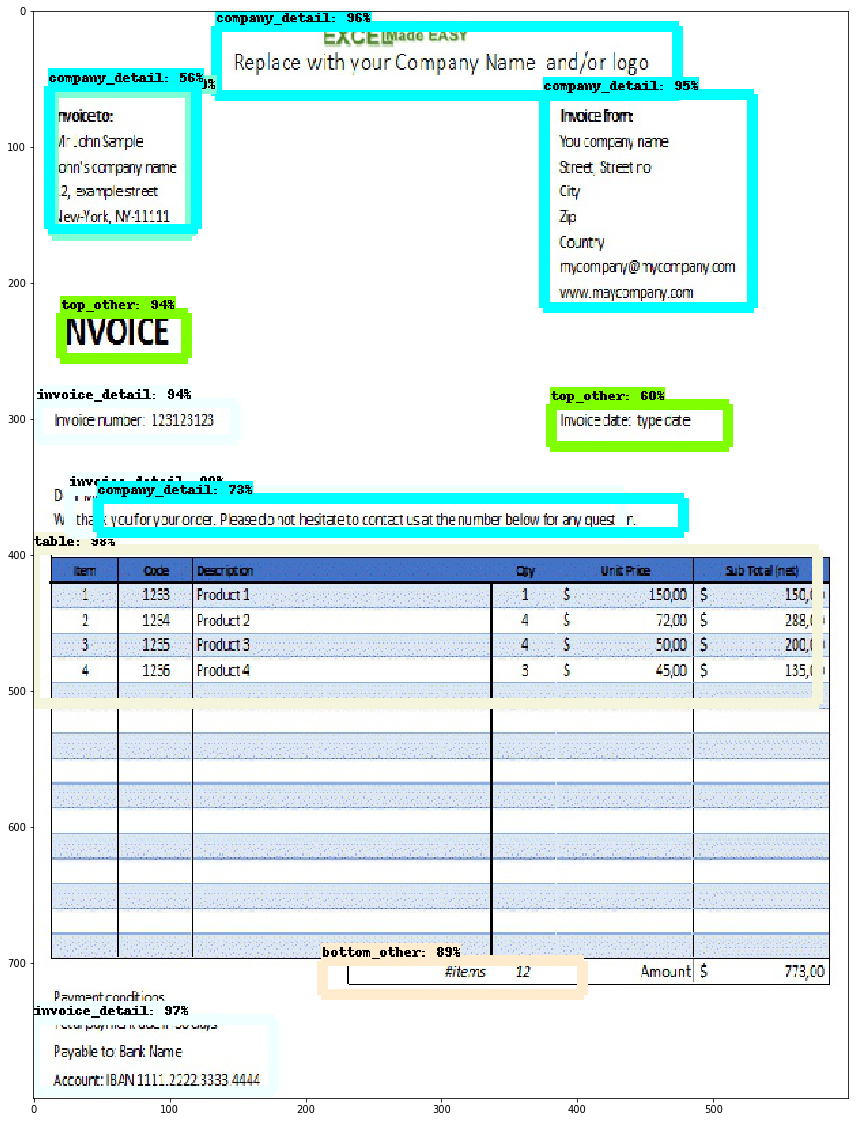

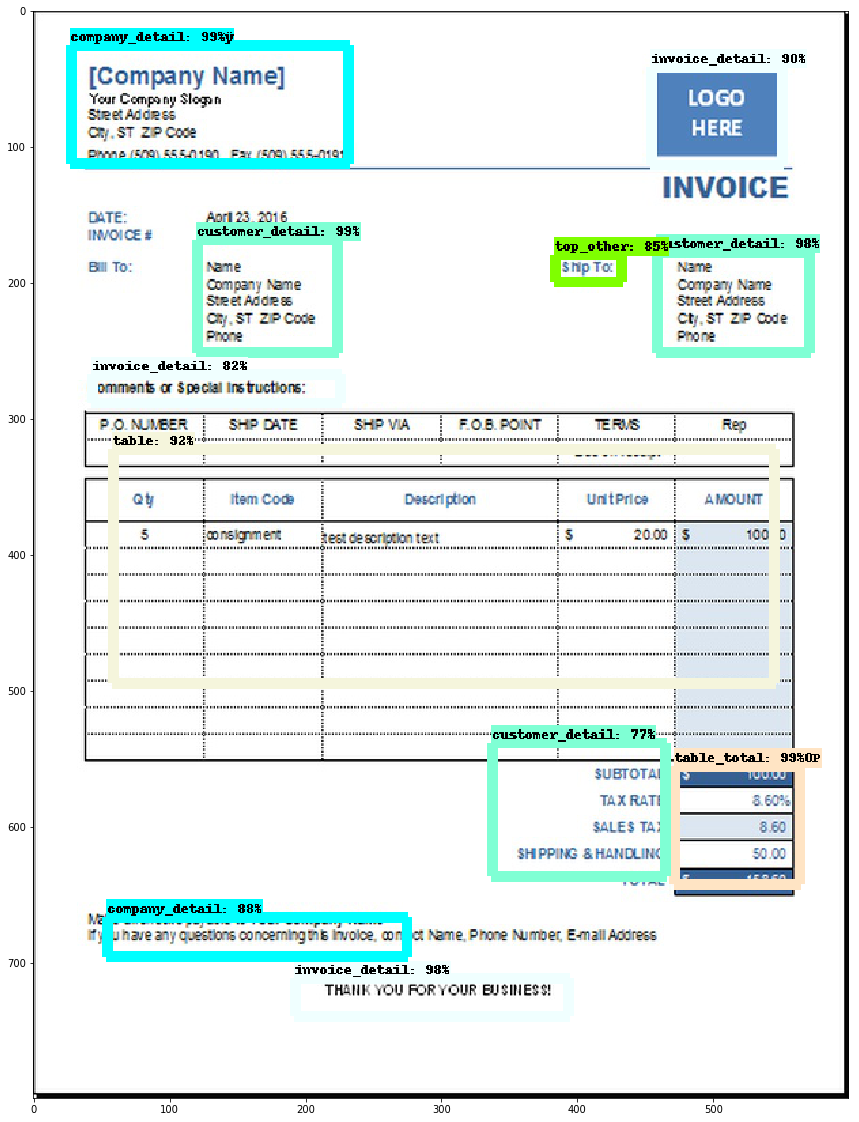

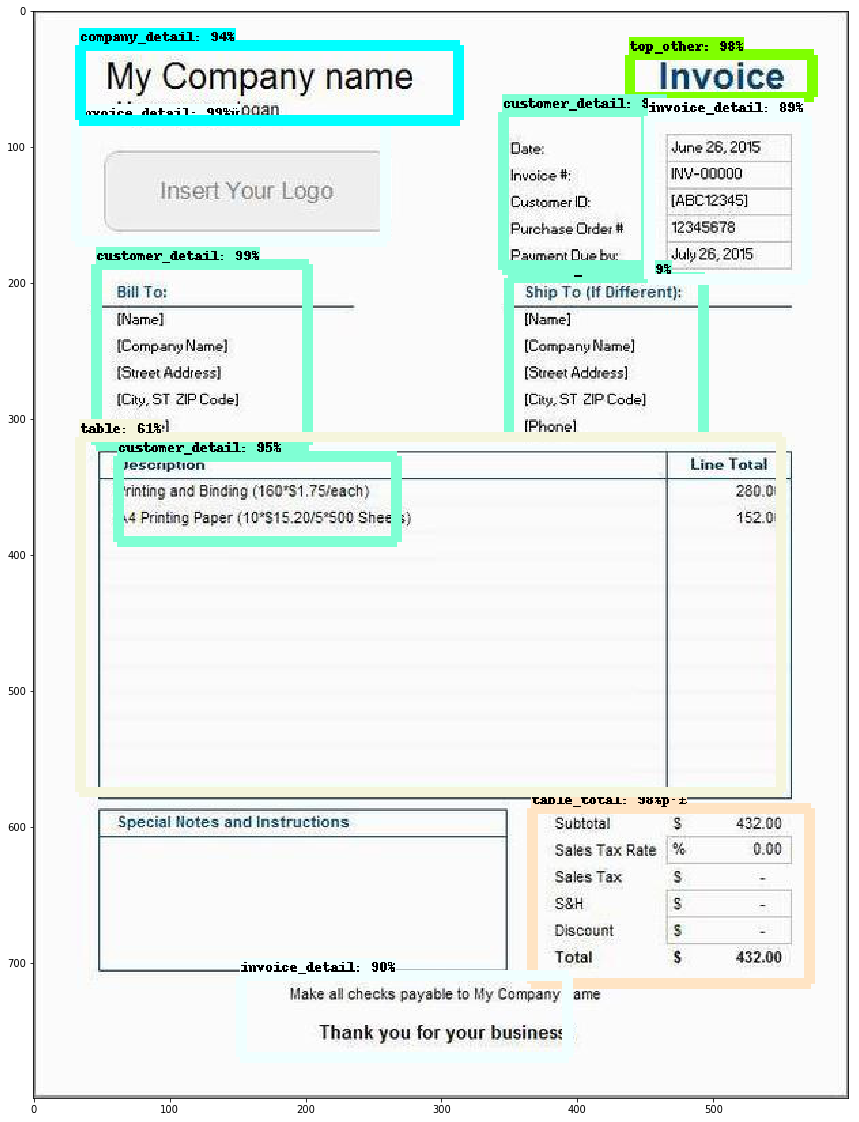

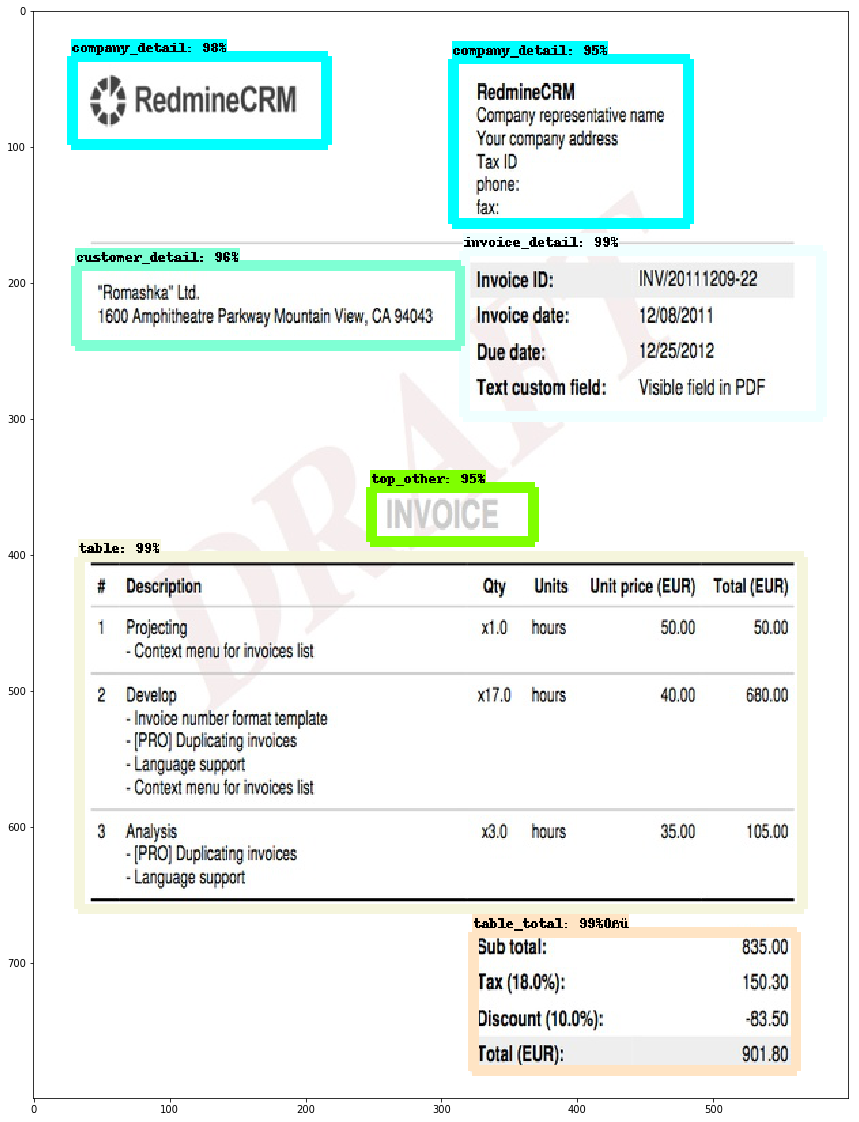

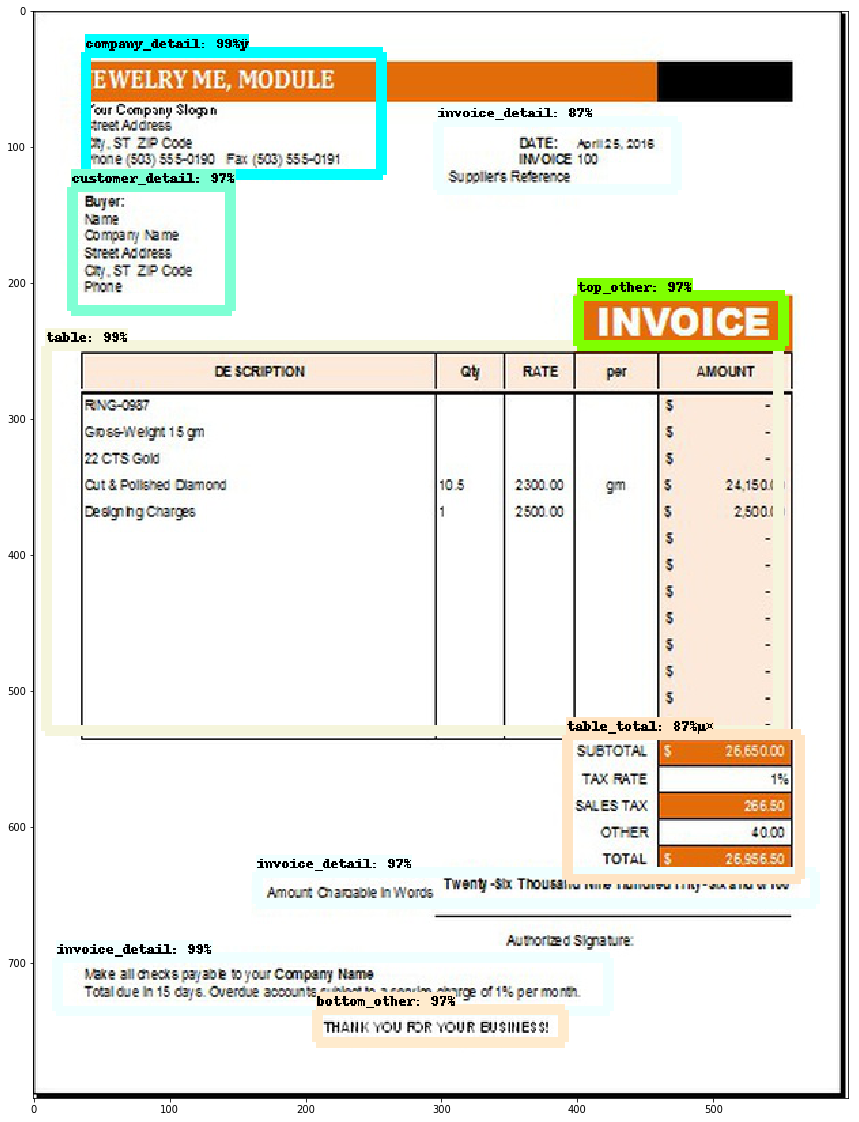

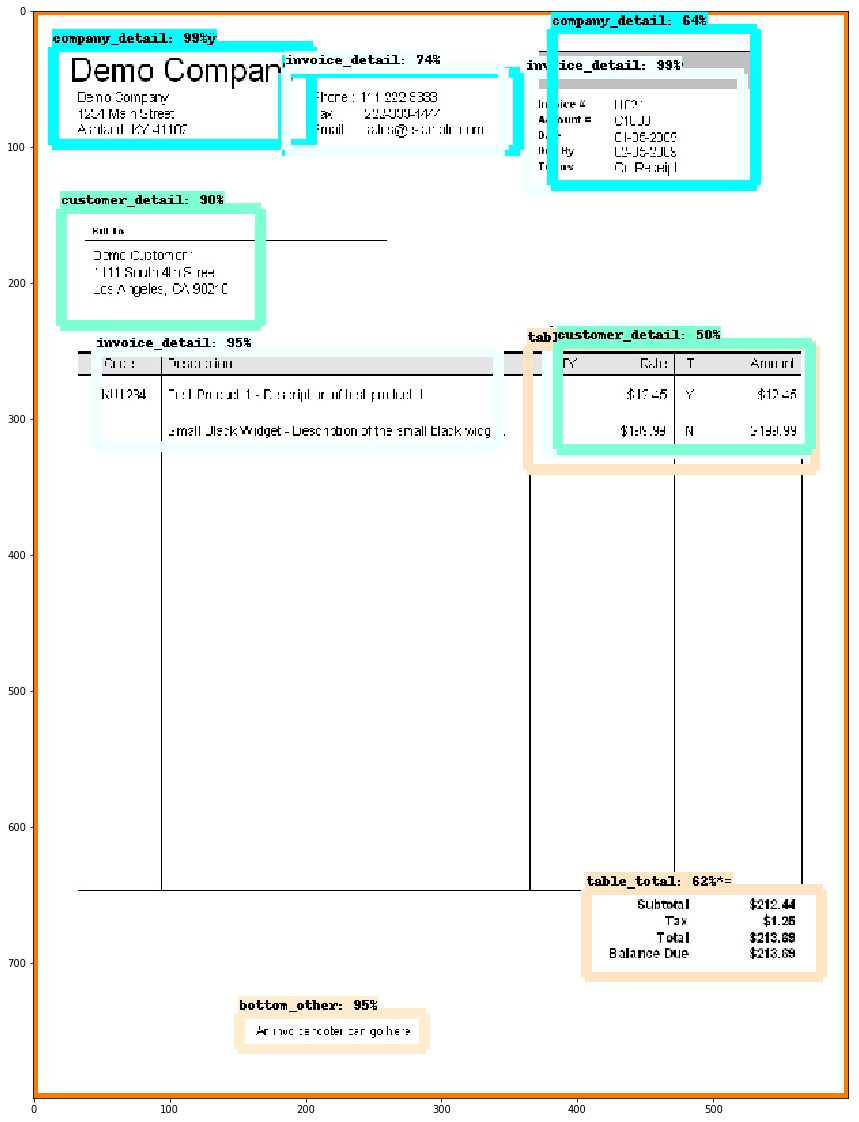

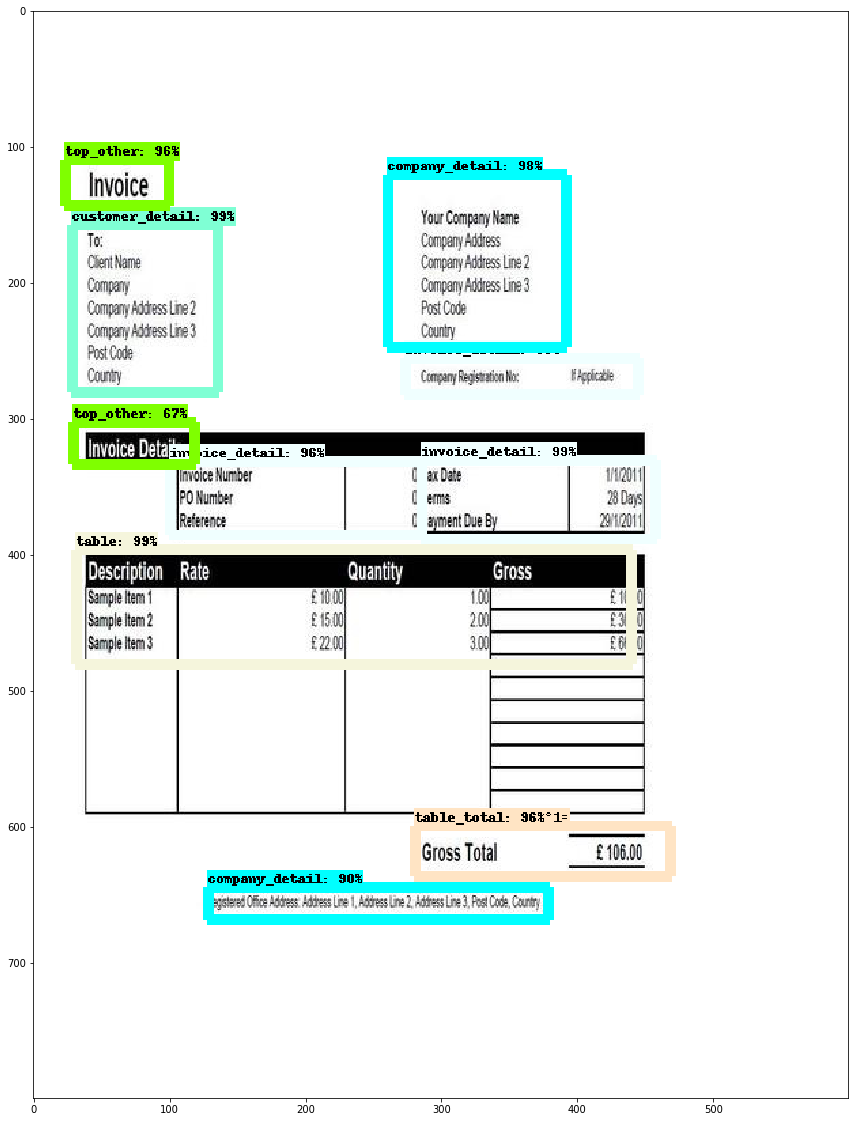

In [39]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=(20,20))
    plt.imshow(image_np)

plt.show()